Realización trabajo detección de fraude

### Integrantes:
- Juan Diego Rodríguez Guarín - 1010109960
- Juan Pablo Medina Díaz - 1000834236

Para este trabajo se hará uso de una librería de Python llamada "imbalanced-learn", la cual nos permitirá analizar los datos del archivo CSV y hacer un análisis de los datos que están desbalanceados

In [216]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder

from collections import Counter

### Cargar los datos desde el archivo CSV

In [217]:
data = pd.read_csv('data/fraud.csv')

In [218]:
data

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
101608,10,PAYMENT,7477.02,C513257306,785.00,0.00,M524833426,0.00,0.00,0,0
101609,10,CASH_OUT,282252.35,C210473293,220339.29,0.00,C1172042998,95156.01,91286.97,0,0
101610,10,PAYMENT,17289.01,C807582280,0.00,0.00,M334249577,0.00,0.00,0,0
101611,10,TRANSFER,1347146.45,C1315779140,1605.00,0.00,C1631408038,541639.43,2186953.43,0,0


In [219]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101613 entries, 0 to 101612
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            101613 non-null  int64  
 1   type            101613 non-null  object 
 2   amount          101613 non-null  float64
 3   nameOrig        101613 non-null  object 
 4   oldbalanceOrg   101613 non-null  float64
 5   newbalanceOrig  101613 non-null  float64
 6   nameDest        101613 non-null  object 
 7   oldbalanceDest  101613 non-null  float64
 8   newbalanceDest  101613 non-null  float64
 9   isFraud         101613 non-null  int64  
 10  isFlaggedFraud  101613 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 8.5+ MB


In [220]:
print(pd.value_counts(data['isFraud'], sort = True))

0    101497
1       116
Name: isFraud, dtype: int64


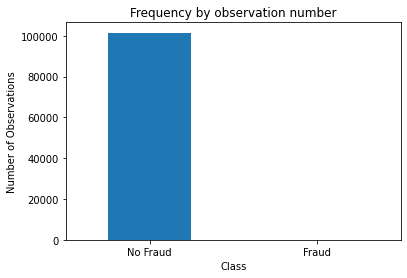

In [221]:
count_classes = pd.value_counts(data['isFraud'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.xticks(range(2), LABELS)
plt.title("Frequency by observation number")
plt.xlabel("Class")
plt.ylabel("Number of Observations");

### Preprocesamiento de datos

In [222]:
data_M = data.copy()

In [223]:
data_M1 = data_M.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis=1)  # Eliminar columnas irrelevantes

In [224]:
data_M1

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,170136.00,160296.36,0.00,0.00,0
1,1,PAYMENT,1864.28,21249.00,19384.72,0.00,0.00,0
2,1,TRANSFER,181.00,181.00,0.00,0.00,0.00,1
3,1,CASH_OUT,181.00,181.00,0.00,21182.00,0.00,1
4,1,PAYMENT,11668.14,41554.00,29885.86,0.00,0.00,0
...,...,...,...,...,...,...,...,...
101608,10,PAYMENT,7477.02,785.00,0.00,0.00,0.00,0
101609,10,CASH_OUT,282252.35,220339.29,0.00,95156.01,91286.97,0
101610,10,PAYMENT,17289.01,0.00,0.00,0.00,0.00,0
101611,10,TRANSFER,1347146.45,1605.00,0.00,541639.43,2186953.43,0


### Separar características y etiquetas


In [225]:
X = data_M1.drop('isFraud', axis=1)
y = data_M1['isFraud']

### División de datos en conjuntos de entrenamiento y prueba

In [226]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Definir las columnas numéricas y categóricas

In [227]:
numeric_features = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
categorical_features = ['type']

### Crear el preprocesador

In [228]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

### Aplicar la transformación a los datos de entrenamiento y prueba

In [229]:
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

### Entrenar un modelo de regresión logística

In [230]:
model = LogisticRegression(C=1.0,penalty='l2',random_state=1,solver="newton-cg")
model.fit(X_train_scaled, y_train)

LogisticRegression(random_state=1, solver='newton-cg')

### Realizar predicciones en el conjunto de prueba

In [231]:
y_pred = model.predict(X_test_scaled)

### Evaluar el rendimiento del modelo

In [232]:
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
classification = classification_report(y_test, y_pred)

### Imprimir los resultados

In [233]:
print("Accuracy:", accuracy)
print("Confusion Matrix:\n", confusion)
print("Classification Report:\n", classification)

Accuracy: 0.9990650986566944
Confusion Matrix:
 [[20303     0]
 [   19     1]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     20303
           1       1.00      0.05      0.10        20

    accuracy                           1.00     20323
   macro avg       1.00      0.53      0.55     20323
weighted avg       1.00      1.00      1.00     20323

